In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import time

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

try:
    torch.set_flush_denormal(True)
    print("Attempted to enable denormal flushing.")
except AttributeError:
    print("torch.set_flush_denormal is not available in this PyTorch version/build for this platform.")
except Exception as e:
    print(f"Could not set denormal flushing: {e}")


# Hyperparameters
NEW_BATCH_SIZE = 256
NUM_EPOCHS_TARGET = 7   # <--- REDUCED to 7 epochs
MAX_LR = 0.02
WEIGHT_DECAY = 1e-4
NUM_WORKERS_DATALOADER = 4
PCT_START_OCLR = 0.20
AUG_PROB = 0.80
CHANNELS_C1 = 10
DIV_FACTOR_OCLR = 20     # <--- CHANGED div_factor
FINAL_DIV_FACTOR_OCLR = 1e5

# Transforms
transform1 = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5,), (0.5,))])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomApply([
        # Keeping augmentation parameters the same for now, focusing on schedule
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
    ], p=AUG_PROB)
])

# DataLoaders
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=NEW_BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_WORKERS_DATALOADER,
                                          pin_memory=(device.type == 'cuda')
                                          )

testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform1)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=NEW_BATCH_SIZE * 2,
                                         shuffle=False,
                                         num_workers=NUM_WORKERS_DATALOADER,
                                         pin_memory=(device.type == 'cuda')
                                         )

# Model Definition
class LeNet5(nn.Module):
    def __init__(self, c1_channels=6):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, c1_channels, 5)
        self.conv2 = nn.Conv2d(c1_channels, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32*1*1, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        self.bn1 = nn.BatchNorm2d(c1_channels)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm1d(120)
        self.bn5 = nn.BatchNorm1d(84)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = nn.ReLU()(self.bn1(self.conv1(x)))
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(self.bn2(self.conv2(x)))
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(self.bn3(self.conv3(x)))
        x = nn.MaxPool2d(2)(x)
        x = x.view(x.size(0), -1)
        x = nn.ReLU()(self.bn4(self.fc1(x)))
        x = nn.ReLU()(self.bn5(self.fc2(x)))
        x = self.fc3(x)
        return x

net = LeNet5(c1_channels=CHANNELS_C1).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=MAX_LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                         max_lr=MAX_LR,
                                         epochs=NUM_EPOCHS_TARGET, # Now 7
                                         steps_per_epoch=len(trainloader),
                                         pct_start=PCT_START_OCLR,
                                         div_factor=DIV_FACTOR_OCLR, # Using new div_factor
                                         final_div_factor=FINAL_DIV_FACTOR_OCLR
                                        )

# Training Loop
start_time = time.time()
print(f"Starting training with num_workers={NUM_WORKERS_DATALOADER} for {NUM_EPOCHS_TARGET} epochs.")
print(f"MAX_LR={MAX_LR}, PCT_START={PCT_START_OCLR}, AUG_PROB={AUG_PROB}, C1_CHANNELS={CHANNELS_C1}, DIV_FACTOR={DIV_FACTOR_OCLR}, FINAL_DIV_FACTOR={FINAL_DIV_FACTOR_OCLR}")
cumulative_time = 0

for epoch in range(NUM_EPOCHS_TARGET):
    net.train()
    running_loss = 0.0
    epoch_start_time = time.time()

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item()
    
    epoch_duration = time.time() - epoch_start_time
    cumulative_time += epoch_duration
    avg_loss = running_loss / len(trainloader)
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{NUM_EPOCHS_TARGET}, Loss: {avg_loss:.4f}, LR: {current_lr:.6f}, Epoch Time: {epoch_duration:.2f}s, Total Time: {cumulative_time:.2f}s')

    net.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data_val in testloader:
            images_val, labels_val = data_val
            images_val, labels_val = images_val.to(device), labels_val.to(device)
            outputs_val = net(images_val)
            _, predicted_val = torch.max(outputs_val.data, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()
    accuracy_val = 100 * correct_val / total_val
    print(f'Epoch {epoch+1}/{NUM_EPOCHS_TARGET}, Validation Accuracy: {accuracy_val:.2f}%')

training_time = time.time() - start_time
print(f"\nTraining finished in {training_time:.2f} seconds.")
print("Trained with an uncompiled (eager) model.")


net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.2f} %')

Using device: mps
PyTorch version: 2.7.0
Attempted to enable denormal flushing.
Starting training with num_workers=4 for 7 epochs.
MAX_LR=0.02, PCT_START=0.2, AUG_PROB=0.8, C1_CHANNELS=10, DIV_FACTOR=20, FINAL_DIV_FACTOR=100000.0
Epoch 1/7, Loss: 0.4326, LR: 0.016474, Epoch Time: 5.01s, Total Time: 5.01s
Epoch 1/7, Validation Accuracy: 93.86%
Epoch 2/7, Loss: 0.1106, LR: 0.019431, Epoch Time: 5.87s, Total Time: 10.87s
Epoch 2/7, Validation Accuracy: 98.05%
Epoch 3/7, Loss: 0.0774, LR: 0.016216, Epoch Time: 4.67s, Total Time: 15.55s
Epoch 3/7, Validation Accuracy: 99.01%
Epoch 4/7, Loss: 0.0633, LR: 0.011096, Epoch Time: 4.66s, Total Time: 20.21s
Epoch 4/7, Validation Accuracy: 98.26%
Epoch 5/7, Loss: 0.0501, LR: 0.005640, Epoch Time: 4.75s, Total Time: 24.96s
Epoch 5/7, Validation Accuracy: 99.18%
Epoch 6/7, Loss: 0.0398, LR: 0.001520, Epoch Time: 4.85s, Total Time: 29.80s
Epoch 6/7, Validation Accuracy: 99.34%
Epoch 7/7, Loss: 0.0342, LR: 0.000000, Epoch Time: 4.84s, Total Time: 34.64

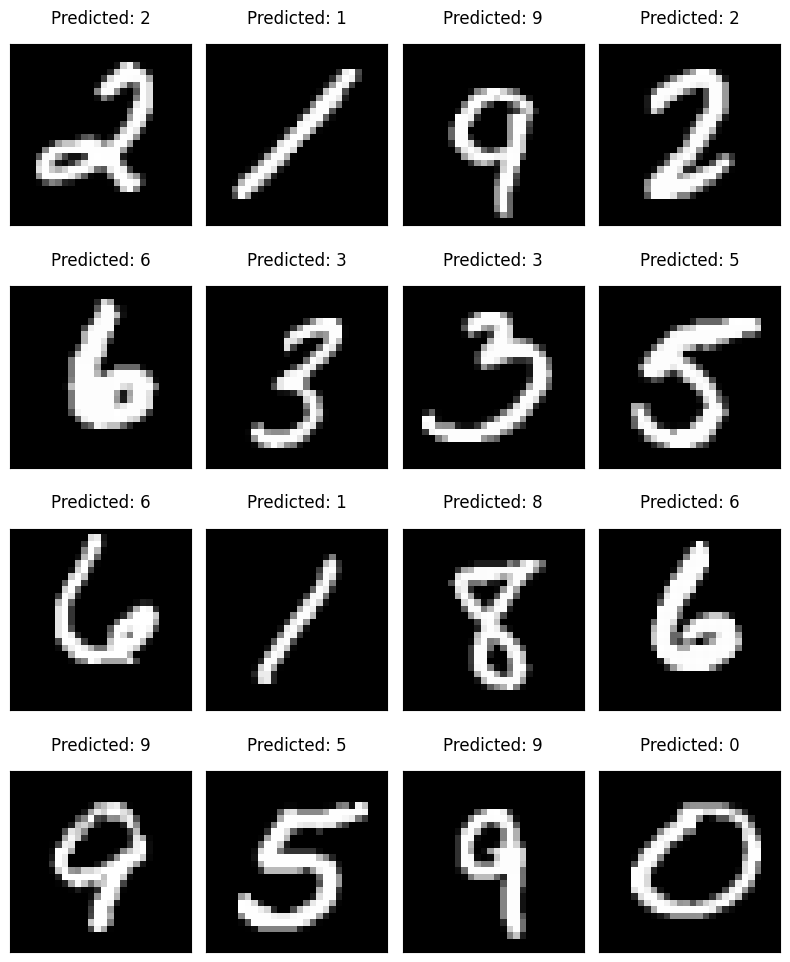

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(8, 10))
for i in range(16):
    ax = axes[i // 4, i % 4]
    ax.imshow(images.cpu()[i].view(28, 28), cmap='gray')
    ax.set_title('Predicted: {}'.format(predicted[i].item()), fontsize=12, pad=15)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()